In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

In [3]:
from importlib import reload
from model import features, pipeline, classifier, plotlib

In [56]:
reload(features)
reload(pipeline)
reload(classifier)
reload(plotlib)

<module 'model.plotlib' from 'D:\\Dropbox\\work-Proj\\Proj-UV-GNR-ML\\code\\model\\plotlib.py'>

In [33]:
import matplotlib
from pathlib import Path
for path in Path("../../../common/fonts/").rglob('*.otf'):
    matplotlib.font_manager.fontManager.addfont(str(path))

In [4]:
plt.style.use("matplotlib.mplstyle")

In [5]:
data = pd.read_csv("../Data/imputed_data.mice.csv")
data = data.assign(coating = data[['lobe', 'full', 'other']].idxmax(axis=1))
data = data.assign(coatingId = data.coating.replace(data.coating.unique(),
                                                    range(len(data.coating.unique()))))

In [9]:
# Sample 6 data points for testing
testIds = data[data.imp == 0].dropna().id.sample(n=6)
print("Test Row IDs:", testIds.values)

# Separate test and training data
testdf = data[data.imp == 0].loc[lambda df: df.id.isin(testIds)]
traindf = data.loc[lambda df: ~df.id.isin(testIds)].dropna()

# Show the testdf
testdf.coating

Test Row IDs: [27 17 21  9 26 14]


8     other
13    other
16     full
20     lobe
25     lobe
26     full
Name: coating, dtype: object

In [10]:
ycol = "coating"

# Build a list of non-collinear features
fnAgg = [features.Differences, features.InverseDifferences]
df = data[data.imp == 0].dropna().drop(['imp', 'id', 'coatingId'], axis=1).set_index('name')

ml = pipeline.Pipeline(df)
ml.AddFeatures(fnAgg, show_list=False)
feats = ml.NonCollinearFeatures(keepCols=['teosVolPct', 'teosVolume'],
                                ignoreCols=['lobe', 'full', 'other', 'quality', 'coating'])
xcols = list(feats.columns)
print("Selected features:", xcols)

feats.to_csv("../Data/x9_selected_feats.csv")

Selected features: ['lsfw2', 'lsfw1', 'tspk2', 'tsfw2', 'itp32', 'tsfw1', 'tspk1', 'teosVolume', 'itw32', 'lp31', 'lspk1', 'lw32', 'teosVolPct', 'ilp21']


In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
df = traindf[traindf.imp == 0]
name = 'obs'

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

In [37]:
X = df.drop(ycol, axis=1)
y = df[ycol]

Xs, ys = ros.fit_resample(X, y)

In [38]:
To = pd.concat([Xs, ys], axis=1)

In [39]:
clf = KNeighborsClassifier()
ml = classifier.New(To, xcols, ycol, fnAgg)
ml.FitModel(clf)

Fitting coating = KNeighborsClassifier() ... OK


C:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        full       0.00      0.00      0.00         2
        lobe       0.00      0.00      0.00         2
       other       0.40      1.00      0.57         2

    accuracy                           0.33         6
   macro avg       0.13      0.33      0.19         6
weighted avg       0.13      0.33      0.19         6

Save OK: ../Plots/x9_conf.obs.KNeighborsClassifier.png


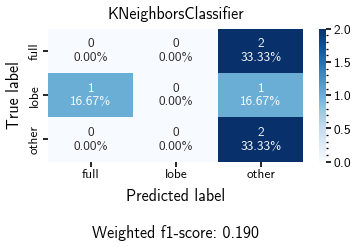

In [40]:
ml.Report(testdf)
ml.Confusion(testdf, savePrefix="../Plots/x9_conf.%s" %name)

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import kernels, GaussianProcessClassifier

# list of tuples of algorithm, gridsearch, and hyperparam space
algorithms = [
    (KNeighborsClassifier, True, dict(
        # The optimal value depends on the nature of the problem
        leaf_size = np.linspace(1, 100, num = 10).astype(int),
        
        # Number of neighbors to use
        n_neighbors = np.linspace(1, 10, num = 10).astype(int),
        
        # Weight function used in prediction
        weights = ['uniform', 'distance'],
        
        # Algorithm used to compute the nearest neighbors
        algorithm= ['auto', 'ball_tree', 'kd_tree', 'brute'],
        
        # manhattan_distance (l1) or euclidean_distance (l2)
        p=[1, 2],
        
        # Parallel processing
        n_jobs = [-1],
    )),
    (SVC, True, dict(
        C=np.linspace(0.001, 1, num=10),
        kernel=['rbf', 'poly', 'linear'],
    )),
    (RandomForestClassifier, False, dict(
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(1, 200, num = 10)],

        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(1, 10)] + [None],

        # Minimum number of samples required to split a node
        min_samples_split = [1, 2],

        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4],

        # Method of selecting samples for training each tree
        bootstrap = [True, False],
        
        # Parallel processing
        n_jobs = [-1],
    )),
    (GaussianProcessClassifier, False, dict(
        kernel = [kernels.RBF(), kernels.RBF() + kernels.WhiteKernel()],
        n_restarts_optimizer = [1, 2, 5],
        max_iter_predict = [10, 100, 1000],
        warm_start = [True, False],
        multi_class = ['one_vs_rest', 'one_vs_one'],
        n_jobs = [-1],
    ))
]

In [45]:
def test_algorithm(alg, gridSearch, hyperParams, cv,
                   Tr, ycol, fnAgg, Ts, name, xcols,
                   featsearch = None):
    """ Perform hyperparam tuning and testing on a given algorithm. """    
    if featsearch is None:
        # use the given features
        clf = alg()
        ml = classifier.New(Tr, xcols, ycol, fnAgg)
        ml.FitModel(clf)
    else:
        # add the featsearch items to the xcols
        clf = alg()
        ml = classifier.New(Tr, featsearch, ycol, fnAgg)
        ml.FitModel(clf)

        # Find the best features
        xcols = ml.FeatureSearch('f1_weighted', 'backward', cv, Ts, 0.2)

        # Create new model with the features
        clf = alg()
        ml = classifier.New(Tr, xcols, ycol, fnAgg)
        ml.FitModel(clf)
    
    # Find the best hyperparams, with k fold CV
    best = ml.HypParamSearch(hyperParams, 'f1_weighted', gridSearch, cv, Ts)
    
    print('best hyperparameters:\n', best.best_params_)
    
    clf = alg(**best.best_params_)
    ml = classifier.New(Tr, xcols, ycol, fnAgg)
    ml.FitModel(clf)
    ml.Report(Ts)
    ml.Confusion(Ts, savePrefix="../Plots/x9_conf.%s" %name)
    return best.best_params_, xcols

Fitting coating = KNeighborsClassifier() ... OK
Running grid search ... OK
best score: 0.9809640368463898
best hyperparameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Fitting coating = KNeighborsClassifier() ... OK
              precision    recall  f1-score   support

        full       0.25      0.50      0.33         2
        lobe       0.00      0.00      0.00         2
       other       0.50      0.50      0.50         2

    accuracy                           0.33         6
   macro avg       0.25      0.33      0.28         6
weighted avg       0.25      0.33      0.28         6

Save OK: ../Plots/x9_conf.imp.KNeighborsClassifier.png


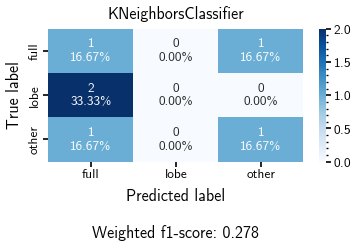

Fitting coating = SVC() ... OK
Running grid search ... OK
best score: 0.9847923406746937
best hyperparameters:
 {'C': 1.0, 'kernel': 'rbf'}
Fitting coating = SVC() ... OK
              precision    recall  f1-score   support

        full       0.40      1.00      0.57         2
        lobe       0.00      0.00      0.00         2
       other       1.00      0.50      0.67         2

    accuracy                           0.50         6
   macro avg       0.47      0.50      0.41         6
weighted avg       0.47      0.50      0.41         6

Save OK: ../Plots/x9_conf.imp.SVC.png


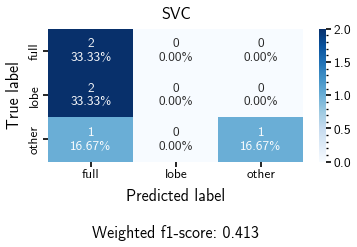

Fitting coating = RandomForestClassifier() ... OK
Running randomized search ... OK
best score: 0.9886447945271474
best hyperparameters:
 {'n_jobs': -1, 'n_estimators': 177, 'min_samples_split': 1, 'min_samples_leaf': 4, 'max_depth': 9, 'bootstrap': True}
Fitting coating = RandomForestClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      1.00      0.50         2
        lobe       0.00      0.00      0.00         2
       other       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

Save OK: ../Plots/x9_conf.imp.RandomForestClassifier.png


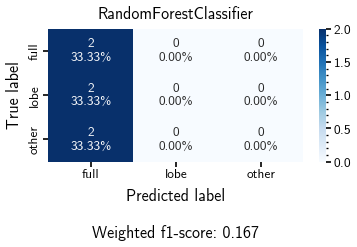

Fitting coating = GaussianProcessClassifier() ... OK
Running randomized search ... 

C:\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


OK
best score: 0.9771332271332271
best hyperparameters:
 {'warm_start': True, 'n_restarts_optimizer': 1, 'n_jobs': -1, 'multi_class': 'one_vs_one', 'max_iter_predict': 10, 'kernel': RBF(length_scale=1)}
Fitting coating = GaussianProcessClassifier() ... OK
              precision    recall  f1-score   support

        full       0.00      0.00      0.00         2
        lobe       0.00      0.00      0.00         2
       other       1.00      0.50      0.67         2

    accuracy                           0.17         6
   macro avg       0.33      0.17      0.22         6
weighted avg       0.33      0.17      0.22         6

Save OK: ../Plots/x9_conf.imp.GaussianProcessClassifier.png


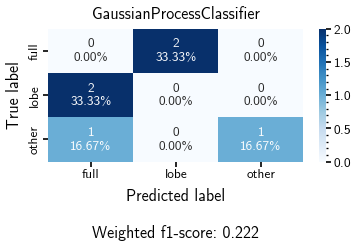

In [49]:
df = traindf[traindf.imp > 0].dropna()
name = 'imp'
cv = 5

# Data Augmentation
ros = RandomOverSampler(random_state=0)
Xs, ys = ros.fit_resample(df.drop(ycol, axis=1), df[ycol])
To = pd.concat([Xs, ys], axis=1)

# Feature search space
ml = pipeline.Pipeline(df)
ml.AddFeatures(fnAgg, show_list=False)
x0 = ml.Tr.columns.drop([
    'imp', 'id', 'quality', 'lobe', 'full', 'other', 'coating', 'coatingId', 'name'])

# Run tests
bestAlg = []
for alg in algorithms:
    h, f = test_algorithm(alg[0], alg[1], alg[2], cv,
                   To, ycol, fnAgg, testdf, name, xcols, featsearch=None)
    bestAlg.append((alg[0], h, f))

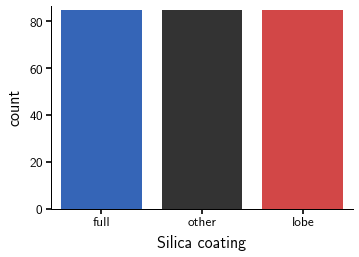

In [50]:
fig, ax = plt.subplots()
sns.countplot(x=To.coating, ax = ax)
plt.minorticks_off()
plt.xlabel("Silica coating")
plt.savefig("../Plots/x9_class_counts.png")
plt.show()

Save OK: ../Plots/x9_class_boxplot_teos.png Height: 1.2


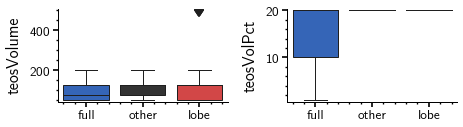

Save OK: ../Plots/x9_class_boxplot_lspr.png Height: 4.0


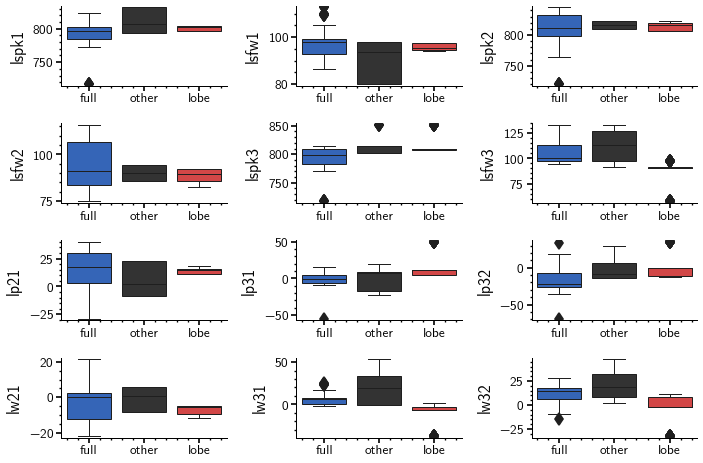

Save OK: ../Plots/x9_class_boxplot_tspr.png Height: 4.0


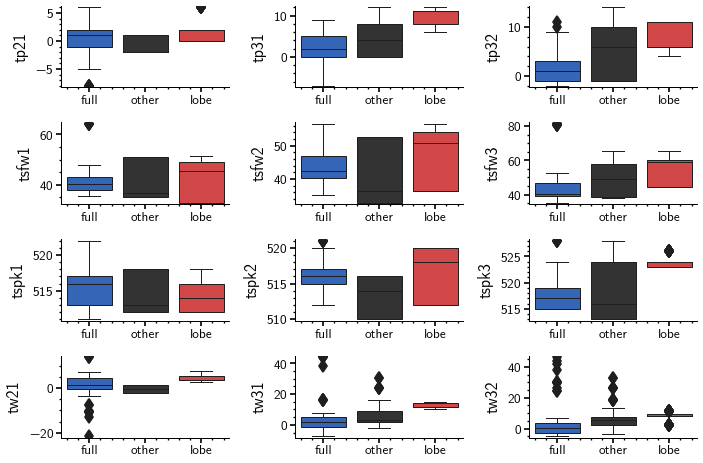

In [53]:
df = To.set_index('name')
ml = pipeline.Pipeline(df)
ml.AddFeatures([features.Differences], show_list=False)
df = ml.Tr.drop(['lobe', 'full', 'other'], axis=1)
cols = df.columns[df.columns.str.startswith('teos')]
plot_class_boxplots(df, cols, 'coating',
                   name = "../Plots/x9_class_boxplot_teos.png")
cols = df.columns[df.columns.str.startswith('l')]
plot_class_boxplots(df, cols, 'coating',
                   name = "../Plots/x9_class_boxplot_lspr.png")
cols = df.columns[df.columns.str.startswith('t')].difference(['teosVolume', 'teosVolPct'])
plot_class_boxplots(df, cols, 'coating',
                   name = "../Plots/x9_class_boxplot_tspr.png")

# SMOTE

In [61]:
df = traindf[traindf.imp > 0].dropna().set_index('name')
cv = 5

# Data Augmentation
Xs, ys = SMOTE().fit_resample(df.drop(ycol, axis=1), df[ycol])
To = pd.concat([Xs, ys], axis=1)

name = 'smote.imp'

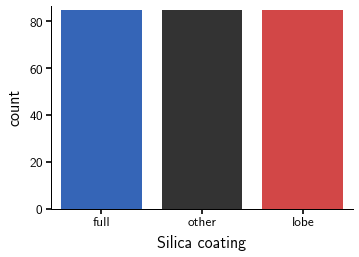

Save OK: ../Plots/x9_class_boxplot_teos.png Height: 1.2


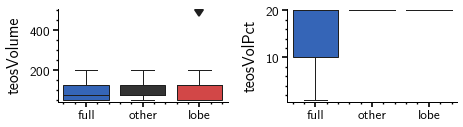

Save OK: ../Plots/x9_class_boxplot_lspr.png Height: 4.0


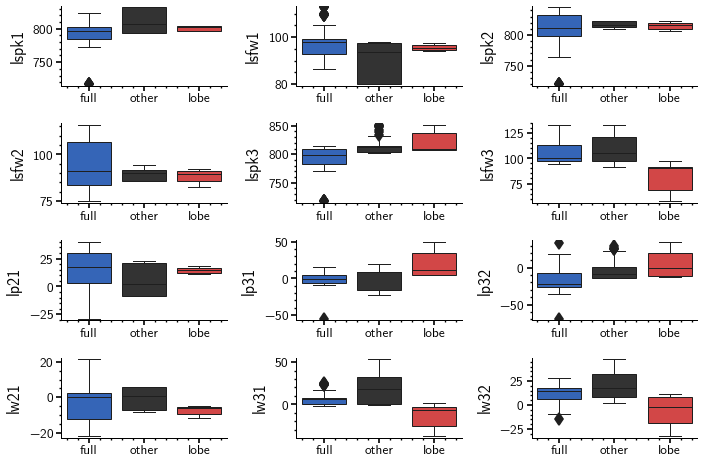

Save OK: ../Plots/x9_class_boxplot_tspr.png Height: 4.0


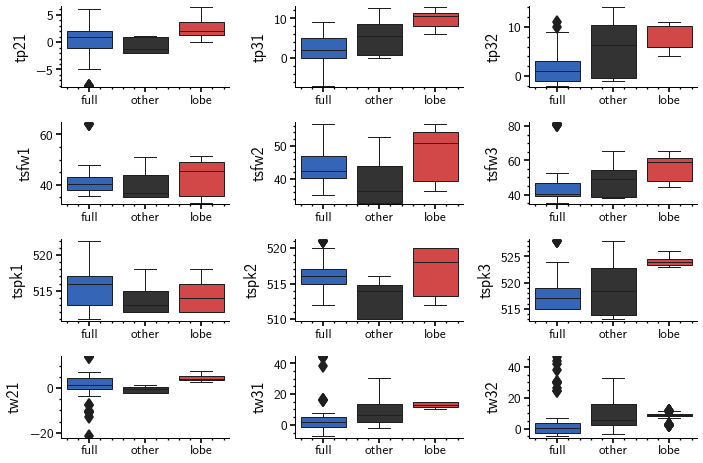

In [62]:
fig, ax = plt.subplots()
sns.countplot(x=To.coating, ax = ax)
plt.minorticks_off()
plt.xlabel("Silica coating")
plt.savefig("../Plots/x9_class_counts.png")
plt.show()

ml = pipeline.Pipeline(To)
ml.AddFeatures([features.Differences], show_list=False)
df = ml.Tr.drop(['lobe', 'full', 'other'], axis=1)
cols = df.columns[df.columns.str.startswith('teos')]
plotlib.class_boxplots(df, cols, 'coating',
                   name = "../Plots/x9_class_boxplot_teos.png")
cols = df.columns[df.columns.str.startswith('l')]
plotlib.class_boxplots(df, cols, 'coating',
                   name = "../Plots/x9_class_boxplot_lspr.png")
cols = df.columns[df.columns.str.startswith('t')].difference(['teosVolume', 'teosVolPct'])
plotlib.class_boxplots(df, cols, 'coating',
                   name = "../Plots/x9_class_boxplot_tspr.png")

Fitting coating = KNeighborsClassifier() ... OK
Running grid search ... OK
best score: 0.9846090846090846
best hyperparameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Fitting coating = KNeighborsClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      0.50      0.40         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.50         6
   macro avg       0.44      0.50      0.47         6
weighted avg       0.44      0.50      0.47         6

Save OK: ../Plots/x9_conf.smote.imp.KNeighborsClassifier.png


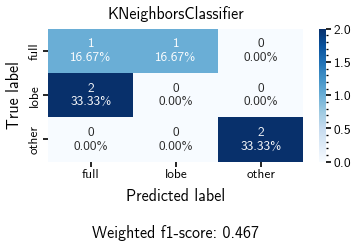

Fitting coating = SVC() ... OK
Running grid search ... OK
best score: 0.9658750859083824
best hyperparameters:
 {'C': 0.778, 'kernel': 'rbf'}
Fitting coating = SVC() ... OK
              precision    recall  f1-score   support

        full       0.40      1.00      0.57         2
        lobe       0.00      0.00      0.00         2
       other       1.00      0.50      0.67         2

    accuracy                           0.50         6
   macro avg       0.47      0.50      0.41         6
weighted avg       0.47      0.50      0.41         6

Save OK: ../Plots/x9_conf.smote.imp.SVC.png


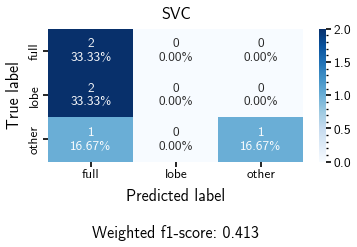

Fitting coating = RandomForestClassifier() ... OK
Running randomized search ... OK
best score: 0.9886447945271474
best hyperparameters:
 {'n_jobs': -1, 'n_estimators': 89, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 7, 'bootstrap': True}
Fitting coating = RandomForestClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      1.00      0.50         2
        lobe       0.00      0.00      0.00         2
       other       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

Save OK: ../Plots/x9_conf.smote.imp.RandomForestClassifier.png


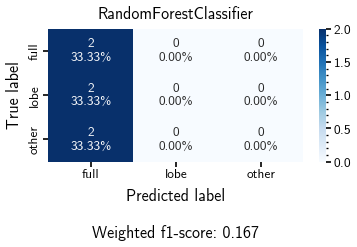

Fitting coating = GaussianProcessClassifier() ... OK
Running randomized search ... 

C:\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


OK
best score: 0.9733032867988181
best hyperparameters:
 {'warm_start': True, 'n_restarts_optimizer': 1, 'n_jobs': -1, 'multi_class': 'one_vs_rest', 'max_iter_predict': 10, 'kernel': RBF(length_scale=1)}
Fitting coating = GaussianProcessClassifier() ... OK
              precision    recall  f1-score   support

        full       0.00      0.00      0.00         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6

Save OK: ../Plots/x9_conf.smote.imp.GaussianProcessClassifier.png


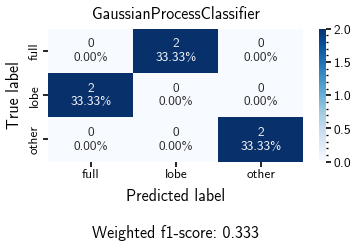

In [65]:
# Feature search space
ml = pipeline.Pipeline(To)
ml.AddFeatures(fnAgg, show_list=False)
x0 = ml.Tr.columns.drop([
    'imp', 'id', 'quality', 'lobe', 'full', 'other', 'coating', 'coatingId'])

# Run tests
bestAlg = []
for alg in algorithms:
    h, f = test_algorithm(alg[0], alg[1], alg[2], cv,
                   To, ycol, fnAgg, testdf, name, xcols, featsearch=None)
    bestAlg.append((alg[0], h, f))

# ADASYN

In [68]:
df = traindf[traindf.imp > 0].dropna().set_index('name')
cv = 5

# Data Augmentation
Xs, ys = ADASYN().fit_resample(df.drop(ycol, axis=1), df[ycol])
To = pd.concat([Xs, ys], axis=1)

name = 'adasyn.imp'

Fitting coating = KNeighborsClassifier() ... OK
Running grid search ... OK
best score: 0.9846090846090846
best hyperparameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Fitting coating = KNeighborsClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      0.50      0.40         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.50         6
   macro avg       0.44      0.50      0.47         6
weighted avg       0.44      0.50      0.47         6

Save OK: ../Plots/x9_conf.adasyn.imp.KNeighborsClassifier.png


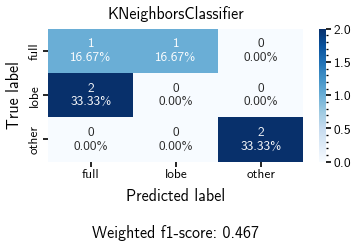

Fitting coating = SVC() ... OK
Running grid search ... OK
best score: 0.9504926026861937
best hyperparameters:
 {'C': 0.889, 'kernel': 'rbf'}
Fitting coating = SVC() ... OK
              precision    recall  f1-score   support

        full       0.25      0.50      0.33         2
        lobe       0.00      0.00      0.00         2
       other       1.00      0.50      0.67         2

    accuracy                           0.33         6
   macro avg       0.42      0.33      0.33         6
weighted avg       0.42      0.33      0.33         6

Save OK: ../Plots/x9_conf.adasyn.imp.SVC.png


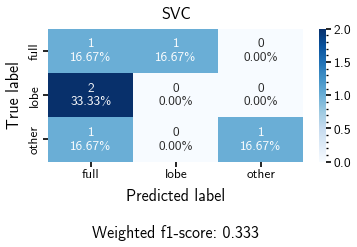

Fitting coating = RandomForestClassifier() ... OK
Running randomized search ... OK
best score: 0.9886447945271474
best hyperparameters:
 {'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': True}
Fitting coating = RandomForestClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      1.00      0.50         2
        lobe       0.00      0.00      0.00         2
       other       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

Save OK: ../Plots/x9_conf.adasyn.imp.RandomForestClassifier.png


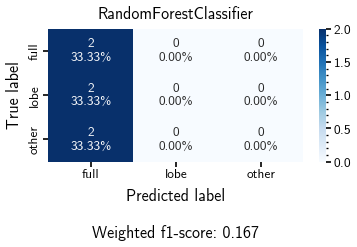

Fitting coating = GaussianProcessClassifier() ... OK
Running randomized search ... 

C:\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


OK
best score: 0.9578367627146761
best hyperparameters:
 {'warm_start': True, 'n_restarts_optimizer': 1, 'n_jobs': -1, 'multi_class': 'one_vs_one', 'max_iter_predict': 10, 'kernel': RBF(length_scale=1) + WhiteKernel(noise_level=1)}
Fitting coating = GaussianProcessClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      0.50      0.40         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.50         6
   macro avg       0.44      0.50      0.47         6
weighted avg       0.44      0.50      0.47         6

Save OK: ../Plots/x9_conf.adasyn.imp.GaussianProcessClassifier.png


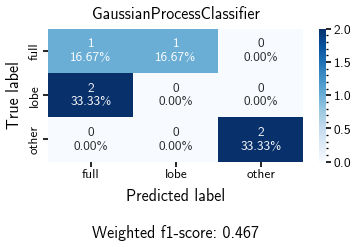

In [69]:
# Feature search space
ml = pipeline.Pipeline(To)
ml.AddFeatures(fnAgg, show_list=False)
x0 = ml.Tr.columns.drop([
    'imp', 'id', 'quality', 'lobe', 'full', 'other', 'coating', 'coatingId'])

# Run tests
bestAlg = []
for alg in algorithms:
    h, f = test_algorithm(alg[0], alg[1], alg[2], cv,
                   To, ycol, fnAgg, testdf, name, xcols, featsearch=None)
    bestAlg.append((alg[0], h, f))

# BorderlineSMOTE

In [71]:
df = traindf[traindf.imp > 0].dropna().set_index('name')
cv = 5

# Data Augmentation
Xs, ys = BorderlineSMOTE().fit_resample(df.drop(ycol, axis=1), df[ycol])
To = pd.concat([Xs, ys], axis=1)

name = 'blsmote.imp'

Fitting coating = KNeighborsClassifier() ... OK
Running grid search ... OK
best score: 0.9846090846090846
best hyperparameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Fitting coating = KNeighborsClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      0.50      0.40         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.50         6
   macro avg       0.44      0.50      0.47         6
weighted avg       0.44      0.50      0.47         6

Save OK: ../Plots/x9_conf.blsmote.imp.KNeighborsClassifier.png


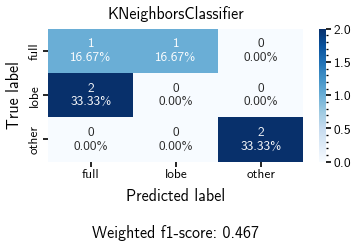

Fitting coating = SVC() ... OK
Running grid search ... OK
best score: 0.9619997743793884
best hyperparameters:
 {'C': 0.667, 'kernel': 'rbf'}
Fitting coating = SVC() ... OK
              precision    recall  f1-score   support

        full       0.50      1.00      0.67         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6

Save OK: ../Plots/x9_conf.blsmote.imp.SVC.png


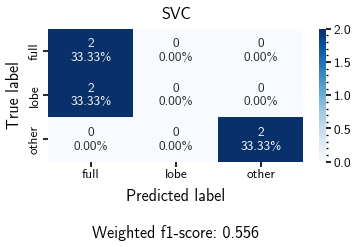

Fitting coating = RandomForestClassifier() ... OK
Running randomized search ... OK
best score: 0.9886447945271474
best hyperparameters:
 {'n_jobs': -1, 'n_estimators': 133, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Fitting coating = RandomForestClassifier() ... OK
              precision    recall  f1-score   support

        full       0.33      1.00      0.50         2
        lobe       0.00      0.00      0.00         2
       other       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

Save OK: ../Plots/x9_conf.blsmote.imp.RandomForestClassifier.png


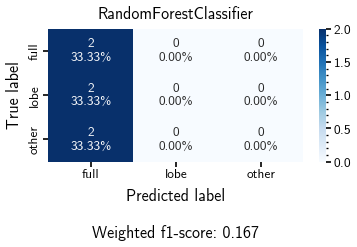

Fitting coating = GaussianProcessClassifier() ... OK
Running randomized search ... 

C:\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


OK
best score: 0.9577430279195344
best hyperparameters:
 {'warm_start': True, 'n_restarts_optimizer': 1, 'n_jobs': -1, 'multi_class': 'one_vs_rest', 'max_iter_predict': 10, 'kernel': RBF(length_scale=1)}
Fitting coating = GaussianProcessClassifier() ... OK
              precision    recall  f1-score   support

        full       0.00      0.00      0.00         2
        lobe       0.00      0.00      0.00         2
       other       1.00      1.00      1.00         2

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6

Save OK: ../Plots/x9_conf.blsmote.imp.GaussianProcessClassifier.png


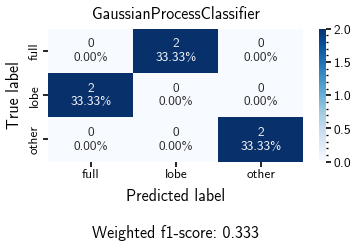

In [72]:
# Feature search space
ml = pipeline.Pipeline(To)
ml.AddFeatures(fnAgg, show_list=False)
x0 = ml.Tr.columns.drop([
    'imp', 'id', 'quality', 'lobe', 'full', 'other', 'coating', 'coatingId'])

# Run tests
bestAlg = []
for alg in algorithms:
    h, f = test_algorithm(alg[0], alg[1], alg[2], cv,
                   To, ycol, fnAgg, testdf, name, xcols, featsearch=None)
    bestAlg.append((alg[0], h, f))

In [73]:
To

,imp,id,tspk1,tsfw1,lspk1,lsfw1,tspk2,tsfw2,lspk2,lsfw2,...,lspk3,lsfw3,teosVolume,teosVolPct,quality,lobe,full,other,coatingId,coating
0,1,1,514,37.365087,794,94.413732,520.000000,51.028356,822.000000,85.849053,...,799.000000,101.710992,125.000000,20,2,0.000000,0.828125,0.171875,0,full
1,1,2,519,64.129804,779,98.099647,520.000000,54.001255,806.000000,89.313601,...,783.000000,104.473499,50.000000,20,2,0.000000,0.800000,0.200000,0,full
2,1,3,511,38.079594,813,90.520202,514.000000,42.576748,812.000000,90.893479,...,810.000000,96.933421,75.000000,20,3,0.078947,0.697368,0.223684,0,full
3,1,4,519,46.014336,772,105.349272,521.000000,51.028356,765.000000,106.424655,...,771.000000,118.127834,75.000000,20,3,0.040000,0.680000,0.280000,0,full
4,1,5,512,35.237926,832,79.944318,510.000000,32.994429,823.000000,85.849053,...,815.000000,112.898500,75.000000,20,2,0.000000,0.023256,0.976744,1,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,4,13,514,40.624018,796,96.927836,514.521609,40.674713,814.174369,91.058137,...,805.390457,107.126680,125.000000,20,5,0.216661,0.025490,0.757850,1,other
251,4,15,513,36.965450,793,98.064683,514.000000,36.505583,816.000000,89.846664,...,802.000000,97.760521,125.000000,20,7,0.293103,0.034483,0.672414,1,other
252,2,5,512,35.237926,832,79.944318,510.000000,32.994429,823.000000,85.849053,...,809.702510,131.240707,75.000000,20,2,0.000000,0.023256,0.976744,1,other
253,1,5,512,35.237926,832,79.944318,510.000000,32.994429,823.000000,85.849053,...,815.000000,109.300910,75.000000,20,2,0.000000,0.023256,0.976744,1,other
